# Semantic Segmentation of Water using U-Net
# Part 3 - Fully Convolutional Neural Network


In this part I will build a FCNN model to perform the semantic segmentation and evaluate the performance to get a baseline.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
import numpy as np
import json, os
from random import shuffle
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
import re

## U-Net Model

The U-Net architecture operates like an AutoEncoder with an encoding or contracting path and a decoding or expanding path. In a U-Net, long skip connections are added between the two paths which allows the decoding path to recover finer grained detail from the encoding path. Finally it tries to predict classes based on a corresponding mask image.

The following images shows the architecture of a U-Net as implemented by [Ronneberger et al.](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) for the segmentation of medical images. They use an input of 572 x 572 x 1 i.e. greyscale image and output a segmentation image of 388 x 388 x 2 with the 2 channels representing the foreground and background respectively.

![](u-net-architecture.png)

This will be the basis of my implementation but I will make a few changes:
- Input image size - Ronneberger et al. used single channel grayscale inputs whereas I am using 3-channel RGB data
- Padding - Ronneberger et al. did not use any padding in their convolutional layers, reducing the image dimensions with the resulting classification being smaller than the input. In my case I want to classify every single pixel and output a classification that is the same size as the input. Therefore I will use padding.
- Output channels - Ronneberger et al. used two channels for their output representing background and objects. I will use just one output channel where each value is the probability that the pixel is water - this can then be thresholded to produce a binary classification map.

To allow me to configure the model in a range of different ways I will include some extra arguments in the model definition.

In [14]:
def UNet(input_shape=(256, 256, 3), n_filters=64, n_blocks=4, model_name='UNet'):
    """Creates UNet Model
    
    Creates and compiles a UNet architecture a la
    Olaf Ronneberger et al.
    
    Parameters
    ----------
    input_shape: tuple of int:
        The dimensions of the input images in the form
        (H,W,C).
    n_filters: int, optional
        The number of filters to use in the first convolution
        block. Default is 64 as used in Ronneberger et al.
    n_blocks: int, optional
        The number of blocks implemented on each path. Default
        is 4 as used in Ronneberger et al.
    model_name: string, optional
        A name to assign to the model.
        
    Returns
    -------
    tensorflow.keras.models.Model:
        The configured U-Net model.
    """
    
    # Reference to input layer
    in_ = Input(input_shape)
    
    # Copy input layer for operations
    x = in_
    
    # Blocks on each side of the UNet architecture
    blocks = n_blocks
    
    # Keep track of layers for concatenation on the DECODE side
    concat_layers = []
    
    ## ---- ENCODER ----
    # An encoder block consists of CONV2D=>CONV2D=>MAXPOOL
    enc_filters = 64
    for block in range(blocks):
        
        # Block of Conv2D & MaxPooling2D
        x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
        
        # Append to layer list for concatenation
        concat_layers.append(x)
        
        x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
        
        # Increase number of filters
        enc_filters *= 2
        
    # Final Conv2D before upsampling
    x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=enc_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
    
    ## ---- DECODER ---- ##
    # A decoder block consists of CONV2DTRANS=>CONCAT=>CONV2D=>CONV2D
    dec_filters = enc_filters / 2
    for block in range(blocks):
        
        # Block of Conv2DTranspose, Concatenate & Conv2D
        x = Conv2DTranspose(dec_filters, kernel_size=(2,2), strides=(2, 2), padding='same') (x)
    
        # Concatenate with corresponding layer output from the encoding side of
        # the UNet.    
        concat = concatenate([concat_layers.pop(), x], axis=3)
        
        x = Conv2D(filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same')(concat)
        x = Conv2D(filters=dec_filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    
        dec_filters /= 2
    
    # ---- OUTPUT ----
    # Output a single channel with the probabilty that the pixel
    # is the positive class e.g. foreground, water etc.
    out_ = Conv2D(1, 1, activation='sigmoid')(x)
    
    model = Model(inputs=in_, outputs=out_, name=model_name)
    
    return model

In [15]:
model = UNet(model_name='baseline_unet') # Default values
model.summary()

Model: "baseline_unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_20[0][0]                  
______________________________________________________________________________________

## Baseline Evaluation

To evaluate ther performance of this model I need some data! I will use the functions defined earlier which are incorporated into my `unetlib` library.

In [2]:
from unetlib.preprocessing import make_dataframes_for_flow, make_img_datagen
from unetlib import visualisation as vs

In [3]:
# Imagery directories
nwpu_data_dir = 'nwpu_lake_images/data/'
nwpu_mask_dir = 'nwpu_lake_images/masks/'

In [4]:
# Split the test/train data
train_img_df, train_msk_df, test_img_df, test_msk_df, = make_dataframes_for_flow(nwpu_data_dir,
                                                                                 nwpu_mask_dir,
                                                                                 test_size=0.25,
                                                                                 random_state=42
                                                                                )

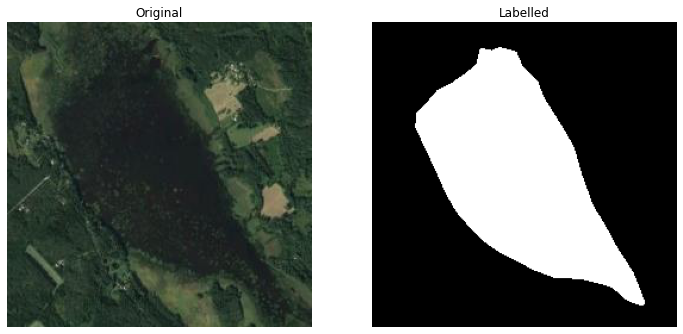

In [5]:
# Plot first image and mask pair of training data
vs.plot_labels(os.path.join(nwpu_data_dir, train_img_df.iat[0,0]),
               os.path.join(nwpu_mask_dir, train_msk_df.iat[0,0]),
               figsize=(12,6)
              )

In [8]:
# Split the training data into train and validation generators
train_gen, val_gen = make_img_datagen(train_img_df, train_msk_df,
                                      nwpu_data_dir, nwpu_mask_dir,
                                      val_split=0.3, rescale=1/255)

Found 210 validated image filenames.
Found 210 validated image filenames.
Found 90 validated image filenames.
Found 90 validated image filenames.


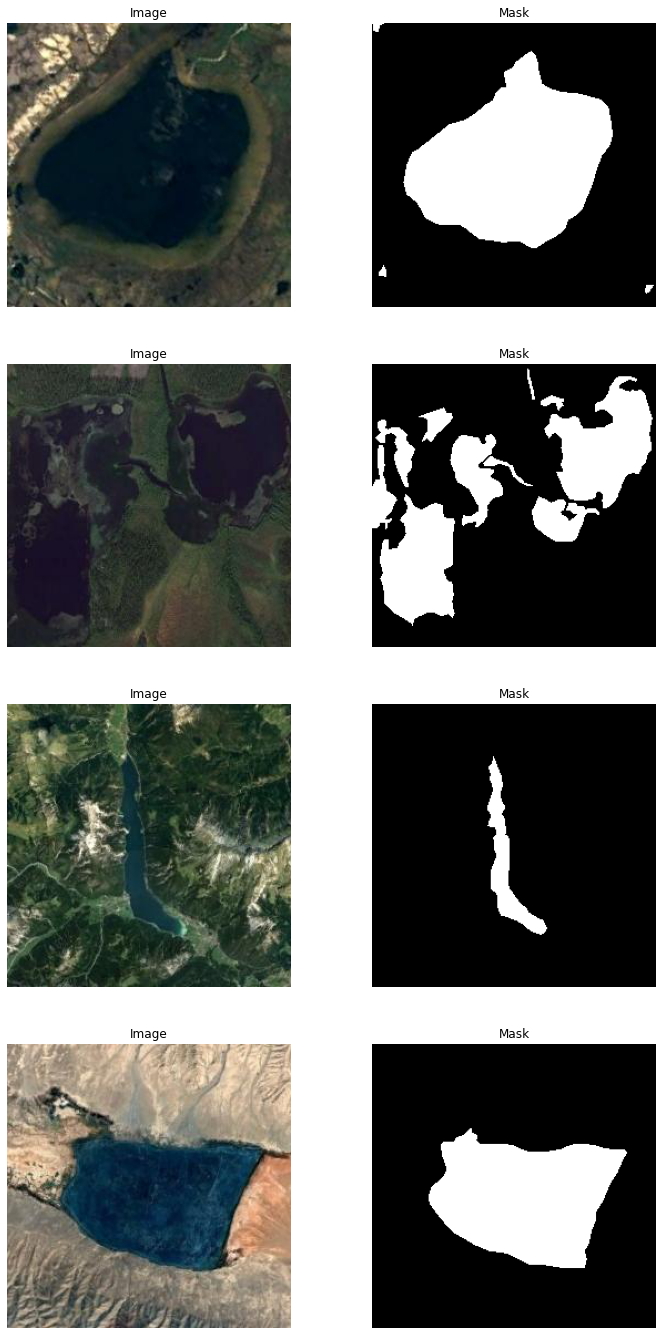

In [9]:
# Plot sample of train batch
train_batch = next(train_gen)
vs.plot_batch(*train_batch, n_images=4, figsize=(12,24))

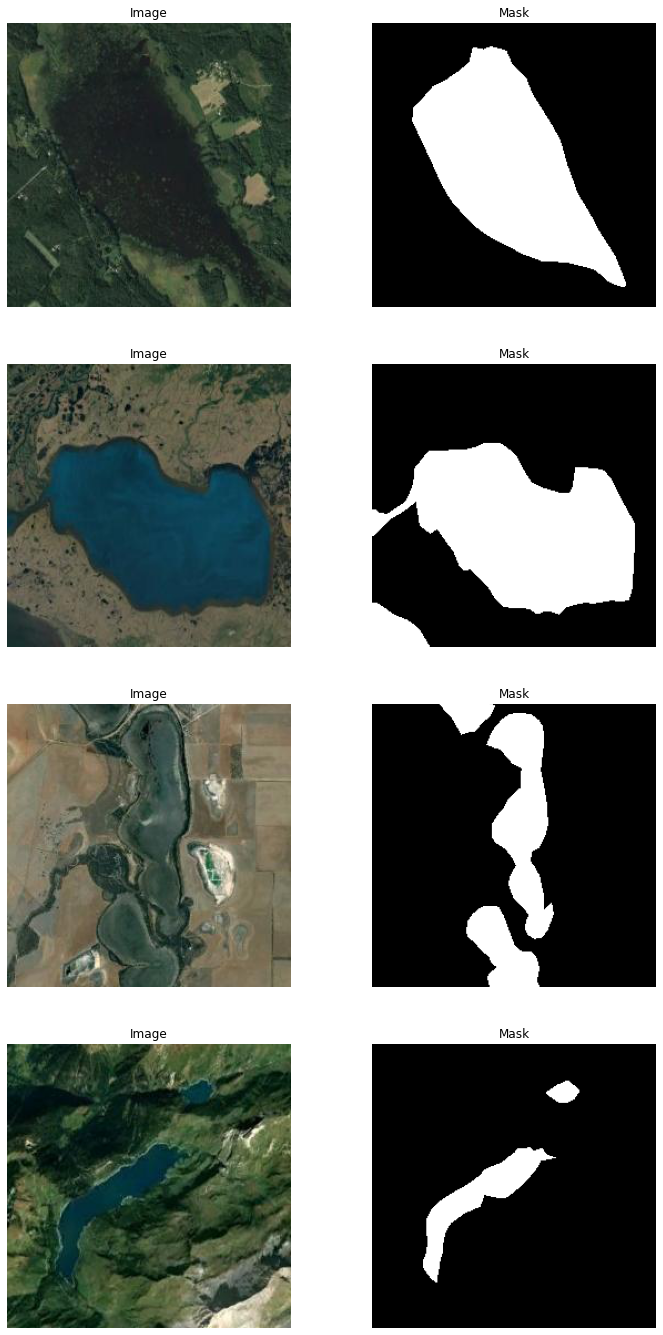

In [10]:
# Plot sample of validation batch
val_batch = next(val_gen)
vs.plot_batch(*val_batch, n_images=4, figsize=(12,24))

## Metrics and Callbacks

In [3]:
def mean_iou(y_true, y_pred):
    """
    """
    
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [4]:
# inheritance for training process plot 
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback function to show a test image and it's predicted
    mask at the end of an epoch
    """
    
    def __init__(self, test_img_dir='.', test_img_fns=None,
                 epoch_freq=1, pred_threshold=None):
        self.test_img_dir = test_img_dir
        
        if test_img_fns is None:
            test_img_fns = os.listdir(test_img_dir)
        
        self.test_img_fns = test_img_fns
        
        self.epoch_freq = epoch_freq
        self.pred_threshold = pred_threshold
        
        super(PlotLearning, self).__init__()

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        
        if self.i % self.epoch_freq != 0:
            return
        
        print(f"Epoch={self.i}\n",
              f"loss={logs.get('loss')}; ",
              f"val_loss={logs.get('val_loss')}\n",
              f"mean_iou={logs.get('mean_iou')}; ",
              f"val_mean_iou={logs.get('val_mean_iou')}",
              sep=''
             )
        
        #choose a random test image and preprocess
        fn = np.random.choice(self.test_img_fns)
        fp = os.path.join(self.test_img_dir, fn)
        img = Image.open(fp)
        # resize to height and width of expected input
        img_arr = np.array(img.resize(model.input_shape[1:-1]))/255.
        
        if img_arr.shape[2] > 3:
            # If more than 3 channels assume RGBA and trim
            # the A channel. Show a warning.
            warnings.warn(f"PlotLearning: Selected test image '{fp}'",
                          f"contains {img_arr.shape[2]} channels. Only the first 3",
                          f"channels have been used."
                         )
            img_arr = img_arr[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(img_arr, 0)).squeeze()
        
        # Report stats
        print('IMG STATS:', img_arr.min(), img_arr.max(),
              img_arr.mean(), img_arr.std(), img_arr.dtype)
        print('MSK STATS', pred.min(), pred.max(),
              pred.mean(), pred.std(), pred.dtype)
        
        #mask thresholding
        t = None or self.pred_threshold
        if t is not None:
            msk_arr = (pred>=t).astype(np.float32) 
            print('MSKT STATS', msk_arr.min(), msk_arr.max(),
                  msk_arr.mean(), msk_arr.std(), msk_arr.dtype)
        else:
            msk_arr = pred
        
        
        # Combine image and mask arrays
        # msk needs to be converted to a 3-channel array to match
        # img.
        msk_arr = np.stack((msk_arr,)*3, axis=-1)
        combined = np.concatenate([img_arr, msk_arr,
                                   img_arr * msk_arr],
                                  axis=1)
        
        # Plot 
        plt.figure(figsize=(12,6))
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [5]:
def build_checkpointer(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                       save_weights_only=True):
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                      monitor=monitor,
                                                      verbose=verbose,
                                                      save_best_only=save_best_only,
                                                      save_weights_only=save_weights_only)
    return checkpointer

## Image Batch Generation

In [6]:
# Image directories - using files from Part 2
s2_img_dir = '../2_Data/s2cloudless_imagery/data/'
s2_msk_dir = '../2_Data/s2cloudless_imagery/masks/'

nwpu_img_dir = '../2_Data/nwpu_images/data/'
nwpu_msk_dir = '../2_Data/nwpu_images/masks/'

In [7]:
def image_filter(filenames, extensions=['jpg','png'], sort=True, as_list=True):
    
    # Also search for lower and upper case extensions
    # The speciifed extensions are kept for cases such as
    # myimgfile.Jpeg etc.
    exts = extensions + [ext.lower() for ext in extensions] \
                        + [ext.upper() for ext in extensions]
    
    # compile pattern
    ptn = re.compile(f"{'|'.join(exts)}$")
    
    # filter filenames
    img_files = filter(lambda s: ptn.search(s), filenames)
    
    if as_list:
        img_files = list(img_files)
        
    if sort:
        img_files = sorted(img_files)
        
    return img_files

In [8]:
# Function to create img & mask paired batches

def img_msk_generator(img_dir, msk_dir, img_size=(512,512), batch_size=16,
                      train_prop=0.8, train_shuffle=False, train_seed=None,
                      img_exts=['jpg','png'],return_fns=False,
                      mask_format="fn.replace('.jpg','_mask.png')",
                      mask_mode='grayscale', mask_threshold=None,
                      img_gen_kwargs={}, msk_gen_kwargs={}, aug_kwargs={},
                      aug_seed=None):
    
    img_fns = image_filter(os.listdir(img_dir),img_exts)
    msk_fns = image_filter(os.listdir(msk_dir),img_exts)
    
    # Handle mapping from img_fns to msk_fns
    if isinstance(mask_format,str):
        mask_func = lambda fn: eval(mask_format) in msk_fns
    elif callable(mask_format):
        mask_func = lambda fn: mask_format(fn)

    # Only use img_fns with a corresponsing mask
    # Files are sorted alhanumerically to ensure
    # img_fns and msk_fns lists are aligned
    img_fns = sorted(filter(mask_func,img_fns))

    # Now create DataFrames to store image paths
    # by default flow_from_dataframe will read paths
    # from a 'filename' column.
    img_df = pd.DataFrame({'filename':img_fns})
    msk_df = pd.DataFrame({'filename':msk_fns})
    
    
    # Train/test split   
    num_train = round(len(img_df) * train_prop)
    
    # Optionally shuffle the images using the specified seed
    if train_shuffle:
        train_img_df = img_df.sample(num_train, random_state=train_seed)
        train_msk_df = msk_df.loc[train_img_df.index]
    else:
        train_img_df = img_df[:num_train]
        train_msk_df = msk_df[:num_train]
        
    test_img_df = img_df[~img_df.index.isin(train_img_df.index)]
    test_msk_df = msk_df.loc[test_img_df.index]
        
    train_fns = train_img_df.filename.values
    test_fns = test_img_df.filename.values
    
    # Set up data generator(s)
    img_datagen = ImageDataGenerator(**aug_kwargs, **img_gen_kwargs)
    
    if mask_threshold is not None:
        thresh_func = lambda t: tf.math.greater(t,mask_threshold)
        msk_datagen = ImageDataGenerator(**aug_kwargs,
                                         **msk_gen_kwargs,
                                         preprocessing_function= thresh_func)
    else:
        msk_datagen = ImageDataGenerator(**aug_kwargs, **msk_gen_kwargs)
        
    # For flows, if augmention is taking place then a seed must be
    # provided to ensure that the image flow and mask flow have
    # the same random transformations applied!
    flow_kwargs = {'y_col': None,
                   'target_size': img_size,
                   'class_mode': None,
                   'shuffle': False,
                   'batch_size': batch_size}
    
    if len(aug_kwargs.items()) > 0:
        try:
            if aug_seed is None:
                aug_seed = 42
            flow_kwargs.update({'seed':int(aug_seed)})
        except TypeError as e:
            e.args = (("Augmentations provided but 'aug_seed' is invalid. "
                       "Must be 'int', 'float', or 'NoneType' to use default seed.",))
            raise e

    # Set up training data flow
    train_img_generator = img_datagen.flow_from_dataframe(
        train_img_df,
        img_dir,
        **flow_kwargs)

    train_msk_generator = msk_datagen.flow_from_dataframe(
        train_msk_df,
        msk_dir,
        color_mode=mask_mode,
        **flow_kwargs)

    train_gen = (pair for pair in zip(train_img_generator, train_msk_generator))
    
    # If prop_train == 1 the entire dataset will be consumed
    # by train_gen so no need to create test_gen!
    if num_train == len(img_df):
        test_gen = None
    else:
        # Set up test data flow
        test_img_generator = img_datagen.flow_from_dataframe(
            test_img_df,
            img_dir,
            **flow_kwargs)

        test_msk_generator = msk_datagen.flow_from_dataframe(
            test_msk_df,
            msk_dir,
            color_mode=mask_mode,
            **flow_kwargs)

        test_gen = (pair for pair in zip(test_img_generator, test_msk_generator))
    
    if return_fns:
        return train_gen, test_gen, train_fns, test_fns
    else:
        return train_gen, test_gen

### Check Batch Generator - No Aug

In [67]:
train_gen, test_gen, train_fns, test_fns = img_msk_generator(img_dir= s2_img_dir,
                                                             msk_dir= s2_msk_dir,
                                                             batch_size=8,
                                                             train_prop=0.6,
                                                             train_shuffle=True,
                                                             train_seed=42,
                                                             return_fns=True,
                                                             mask_threshold=128,
                                                             img_gen_kwargs={'rescale':1/255.}
                                                            )

Found 24 validated image filenames.
Found 24 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.


In [68]:
train_fns

array(['mead_mojave_s2cloudless-2018.jpg',
       'koroneia_s2cloudless-2017.jpg', 'koroneia_s2cloudless-2016.jpg',
       'qinghai_s2cloudless-2016.jpg', 'balaton_s2cloudless-2018.jpg',
       'elephant_butte_s2cloudless-2018.jpg',
       'urmia_s2cloudless-2018.jpg', 'qinghai_s2cloudless-2018.jpg',
       'walker_s2cloudless-2018.jpg', 'burdur_s2cloudless-2017.jpg',
       'poopo_s2cloudless-2018.jpg', 'copais_s2cloudless-2017.jpg',
       'faguibine_s2cloudless-2016.jpg', 'salda_s2cloudless-2017.jpg',
       'salton_sea_s2cloudless-2018.jpg', 'copais_s2cloudless-2016.jpg',
       'koroneia_s2cloudless-2018.jpg', 'poopo_s2cloudless-2016.jpg',
       'aral_sea_s2cloudless-2016.jpg', 'salton_sea_s2cloudless-2016.jpg',
       'burdur_s2cloudless-2016.jpg',
       'elephant_butte_s2cloudless-2016.jpg',
       'aral_sea_s2cloudless-2018.jpg', 'ramganga_s2cloudless-2018.jpg'],
      dtype=object)

In [69]:
test_fns

array(['balaton_s2cloudless-2016.jpg', 'balaton_s2cloudless-2017.jpg',
       'burdur_s2cloudless-2018.jpg', 'copais_s2cloudless-2018.jpg',
       'faguibine_s2cloudless-2018.jpg',
       'mead_mojave_s2cloudless-2016.jpg',
       'mendocino_s2cloudless-2016.jpg', 'mendocino_s2cloudless-2018.jpg',
       'mono_s2cloudless-2016.jpg', 'mono_s2cloudless-2018.jpg',
       'ramganga_s2cloudless-2016.jpg', 'salda_s2cloudless-2016.jpg',
       'salda_s2cloudless-2018.jpg', 'urmia_s2cloudless-2016.jpg',
       'urmia_s2cloudless-2017.jpg', 'walker_s2cloudless-2016.jpg'],
      dtype=object)

In [38]:
# Get batch
train_X, train_y = next(train_gen)
test_X, test_y = next(test_gen)

In [39]:
print(train_X.shape, train_X.dtype, train_y.shape, train_y.dtype)
print(test_X.shape, test_X.dtype, test_y.shape, test_y.dtype)

(8, 512, 512, 3) float32 (8, 512, 512, 1) float32
(8, 512, 512, 3) float32 (8, 512, 512, 1) float32


In [40]:
print((train_X.min(), train_X.max()), (train_y.min(), train_y.max()))
print((test_X.min(), test_X.max()), (test_y.min(), test_y.max()))

(0.0, 1.0) (0.0, 1.0)
(0.0, 1.0) (0.0, 1.0)


Image index: 3
0.0 1.0 0.34072068 0.19948603 float32
0.0 1.0 0.1788559 0.3832316 float32


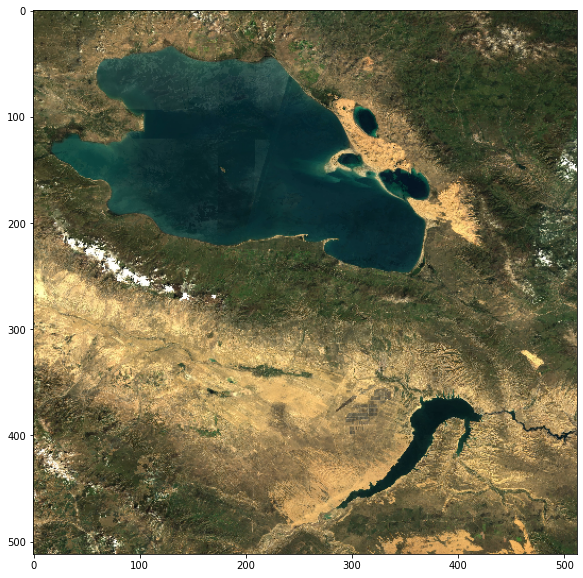

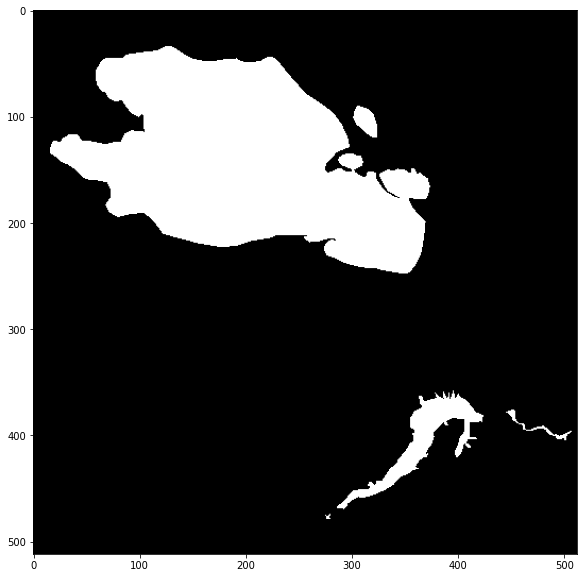

In [41]:
# Examine a random training image/mask pair
img_idx = np.random.randint(8)
print(f'Image index: {img_idx}')

img = train_X[img_idx,:,:,:]
msk = train_y[img_idx,:,:,0]

print(img.min(),img.max(),img.mean(),img.std(),img.dtype)
print(msk.min(),msk.max(),msk.mean(),msk.std(),msk.dtype)

plt.figure(figsize=(10,10))
plt.imshow(img)

plt.figure(figsize=(10,10))
plt.imshow(msk,cmap='gray')

In [42]:
# The mask images should contain only 0 and 1 values (if rescaled) or 0 and 255 if no rescaling
# since they are stored as 8bit images on disk.

# Sometimes, due to artifacts in resizing and interpolating other floating point values can be introduced
# so this check ensures the binary mask is valid i.e. no other values.

# Check that all mask pixels are either 0 or 1
all_valid_scaled = np.isin(msk,[0,1]).sum() == msk.shape[0] * msk.shape[1]

# Alternatively, check that all values are either 0 or 255
all_valid_unscaled = np.isin(msk,[0,255]).sum() == msk.shape[0] * msk.shape[1]

print('One of the below must be true depending on whether',
      'the masks were rescaled via the mask_threshold argument to',
      'img_msk_generator.'
     )
print(f'\n{all_valid_scaled}\n{all_valid_unscaled}')

One of the below must be true depending on whether the masks were rescaled via the mask_threshold argument to img_msk_generator.

True
False


### Check Batch Generator - With Aug

In [76]:
aug_dict = {'zoom_range':0.2,
            'rotation_range':45,
            'horizontal_flip':True,
            'vertical_flip':True}

train_gen, test_gen, train_fns, test_fns = img_msk_generator(img_dir= s2_img_dir,
                                                             msk_dir= s2_msk_dir,
                                                             batch_size=8,
                                                             train_prop=0.6,
                                                             train_shuffle=True,
                                                             train_seed=42,
                                                             return_fns=True,
                                                             mask_threshold=128,
                                                             img_gen_kwargs={'rescale':1/255.},
                                                             aug_kwargs= aug_dict
                                                            )

Found 24 validated image filenames.
Found 24 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.


In [77]:
train_fns

array(['mead_mojave_s2cloudless-2018.jpg',
       'koroneia_s2cloudless-2017.jpg', 'koroneia_s2cloudless-2016.jpg',
       'qinghai_s2cloudless-2016.jpg', 'balaton_s2cloudless-2018.jpg',
       'elephant_butte_s2cloudless-2018.jpg',
       'urmia_s2cloudless-2018.jpg', 'qinghai_s2cloudless-2018.jpg',
       'walker_s2cloudless-2018.jpg', 'burdur_s2cloudless-2017.jpg',
       'poopo_s2cloudless-2018.jpg', 'copais_s2cloudless-2017.jpg',
       'faguibine_s2cloudless-2016.jpg', 'salda_s2cloudless-2017.jpg',
       'salton_sea_s2cloudless-2018.jpg', 'copais_s2cloudless-2016.jpg',
       'koroneia_s2cloudless-2018.jpg', 'poopo_s2cloudless-2016.jpg',
       'aral_sea_s2cloudless-2016.jpg', 'salton_sea_s2cloudless-2016.jpg',
       'burdur_s2cloudless-2016.jpg',
       'elephant_butte_s2cloudless-2016.jpg',
       'aral_sea_s2cloudless-2018.jpg', 'ramganga_s2cloudless-2018.jpg'],
      dtype=object)

In [78]:
# Get batch
train_X, train_y = next(train_gen)
test_X, test_y = next(test_gen)

In [79]:
print(train_X.shape, train_X.dtype, train_y.shape, train_y.dtype)
print(test_X.shape, test_X.dtype, test_y.shape, test_y.dtype)

(8, 512, 512, 3) float32 (8, 512, 512, 1) float32
(8, 512, 512, 3) float32 (8, 512, 512, 1) float32


In [80]:
print((train_X.min(), train_X.max()), (train_y.min(), train_y.max()))
print((test_X.min(), test_X.max()), (test_y.min(), test_y.max()))

(0.0, 1.0) (0.0, 1.0)
(0.0, 1.0) (0.0, 1.0)


<div class="alert alert-block alert-warning"><b>Warning:</b> Note that using the augmentation seems to affect the global numpy seed; see <a href="image_gen_seed.ipynb">image_gen_seed.ipynb.</a> In the following cell I reset the seed before generating a random image index.</div>

In [81]:
print(np.random.randint(8,size=8)) # sequence of indices if seed is not reset after first batch

# Note: to reproduce the same sequencee of indices as in the
# image_gen_seed notebook, the batch size in the call to img_msk_generater
# should be set to 16 and the high value used for randint also set to 16.

[6 3 4 7 6 2 5 0]


Image index: 7
0.0 0.9834242 0.37377703 0.17400852 float32
0.0 1.0 0.22153854 0.4152821 float32


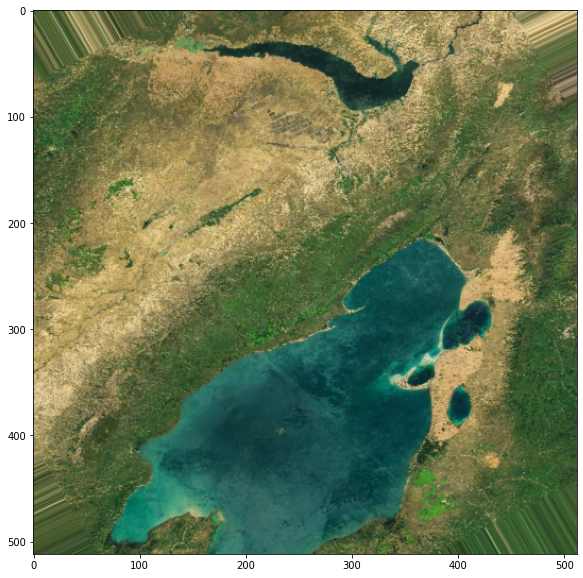

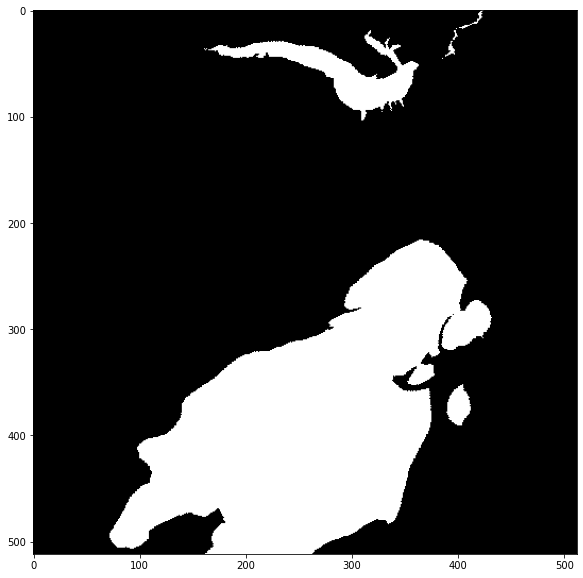

In [42]:
# Examine a random training image/mask pair
# np.random.seed()
img_idx = np.random.randint(8)
print(f'Image index: {img_idx}')

img = train_X[img_idx,:,:,:]
msk = train_y[img_idx,:,:,0]

print(img.min(),img.max(),img.mean(),img.std(),img.dtype)
print(msk.min(),msk.max(),msk.mean(),msk.std(),msk.dtype)

plt.figure(figsize=(10,10))
plt.imshow(img)

plt.figure(figsize=(10,10))
plt.imshow(msk,cmap='gray')

## Model Fitting

### S2 Cloudless - Non Augmented Data

In [44]:
s2_batch_size = 4
s2_prop_train = 0.6

# No augmentations
s2_train_gen, s2_test_gen, s2_train_fns, s2_test_fns = img_msk_generator(img_dir= s2_img_dir,
                                                                         msk_dir= s2_msk_dir,
                                                                         batch_size=s2_batch_size,
                                                                         train_prop=s2_prop_train,
                                                                         train_shuffle=True,
                                                                         train_seed=42,
                                                                         return_fns=True,
                                                                         mask_threshold=128,
                                                                         img_gen_kwargs={'rescale':1/255.}
                                                                        )

s2_train_steps = len(s2_train_fns) // s2_batch_size
s2_valid_steps = len(s2_test_fns) // s2_batch_size

print(f'Steps per training epoch: {s2_train_steps}')
print(f'Steps per testing epoch: {s2_valid_steps}')

Found 24 validated image filenames.
Found 24 validated image filenames.
Found 16 validated image filenames.
Found 16 validated image filenames.
Steps per training epoch: 6
Steps per testing epoch: 4


Epoch=5
loss=0.3590189218521118; val_loss=0.38251635432243347
mean_iou=0.0; val_mean_iou=0.0
IMG STATS: 0.0 1.0 0.5679085974599802 0.21666896829124954 float64
MSK STATS 0.0010994971 0.4482407 0.029539777 0.03479809 float32
MSKT STATS 0.0 0.0 0.0 0.0 float32


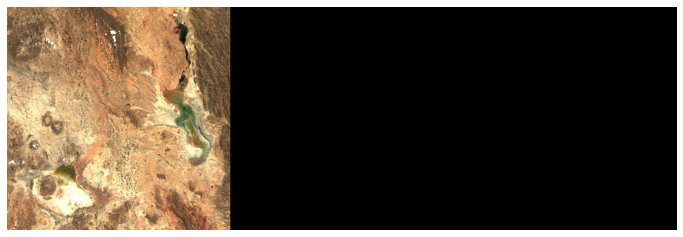

Epoch=10
loss=0.23532633483409882; val_loss=0.30471158027648926
mean_iou=0.0; val_mean_iou=0.21241477131843567
IMG STATS: 0.06274509803921569 1.0 0.612071791505502 0.22054226197212182 float64
MSK STATS 0.0013481379 0.40249094 0.029140886 0.03618588 float32
MSKT STATS 0.0 0.0 0.0 0.0 float32


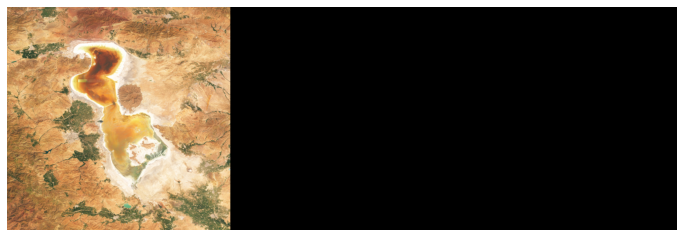

Epoch=15
loss=0.2069808691740036; val_loss=0.30165308713912964
mean_iou=0.5871565341949463; val_mean_iou=0.730681300163269
IMG STATS: 0.08235294117647059 1.0 0.5778692208084406 0.16967117524695163 float64
MSK STATS 3.2785824e-06 0.2782555 0.00049899844 0.00395695 float32
MSKT STATS 0.0 0.0 0.0 0.0 float32


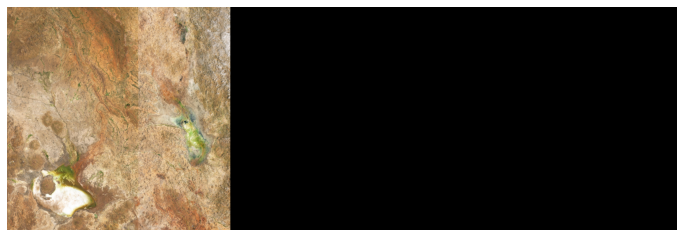

Epoch=20
loss=0.14206990599632263; val_loss=0.28556257486343384
mean_iou=0.712563693523407; val_mean_iou=0.7389543652534485
IMG STATS: 0.08235294117647059 1.0 0.5778692208084406 0.16967117524695163 float64
MSK STATS 4.0525956e-06 0.18682617 0.00033944912 0.002560329 float32
MSKT STATS 0.0 0.0 0.0 0.0 float32


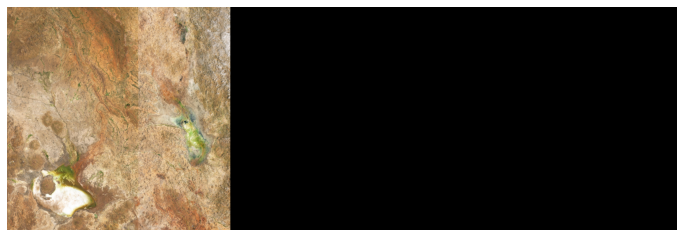

Epoch=25
loss=260.4555358886719; val_loss=0.39232105016708374
mean_iou=0.36038342118263245; val_mean_iou=0.5629981756210327
IMG STATS: 0.054901960784313725 0.9098039215686274 0.29314370248831956 0.09114562537029912 float64
MSK STATS 0.07910329 0.9666294 0.71597904 0.11650033 float32
MSKT STATS 0.0 1.0 0.9585571 0.19931222 float32


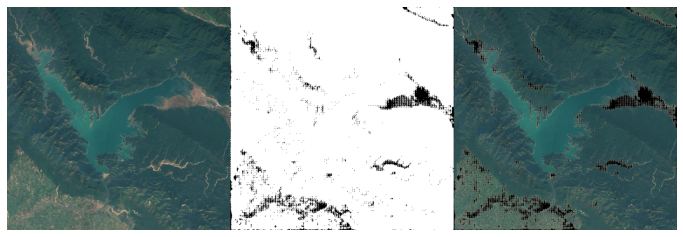

Epoch=30
loss=0.17087405920028687; val_loss=0.27437320351600647
mean_iou=0.6523452401161194; val_mean_iou=0.7260282635688782
IMG STATS: 0.0 1.0 0.24404914207707826 0.15304339378076673 float64
MSK STATS 0.0002939105 0.8907515 0.29575378 0.30137506 float32
MSKT STATS 0.0 1.0 0.42256165 0.49396688 float32


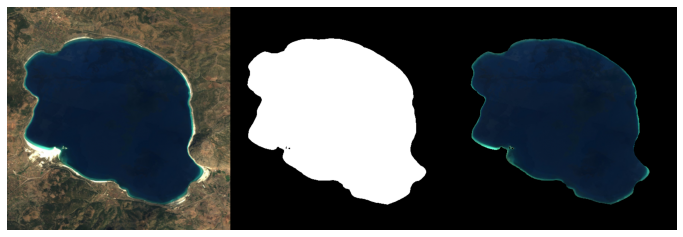

In [11]:
# Configure callbacks
s2_callbacks = [PlotLearning(test_img_dir=s2_img_dir,
                             test_img_fns=s2_test_fns,
                             epoch_freq=5, pred_threshold=0.5),
                build_checkpointer(filepath='unet_s2.h5')]

# Initialise model
model = UNet()

# Configure optimiser, loss, and metrics
s2_opt = 'rmsprop' # default lr=0.001
# or decrease lr
# s2_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(s2_opt,
              loss='binary_crossentropy',
              metrics =[mean_iou])

# Fit model
s2_epochs = 30
s2_history = model.fit(s2_train_gen,
                       epochs=s2_epochs,
                       steps_per_epoch=s2_train_steps,
                       validation_data=s2_test_gen,
                       validation_steps=s2_valid_steps,
                       callbacks=s2_callbacks,
                       verbose=0)

The predcition output for most images is <0.5 therefore using 0.5 as a non-water/water threshold - via `pred >= 0.5` doesnt work since all mask pixels will be False and 0 in the output i.e. no water predicted! This results in the Plotting callback showing the test image, mask of all 0 values and then mask * image which is also all zeros.

Similarly the IoU metric defined earlier uses the 0.5 threshold resulting in mean_iou values of 0.0.

This problem is more apparent in the early stages of training as the non-water/water predictions will not be of high confidence (e.g. < 0.5). As the network learns and becomes more confident this issue should dissiptate. Note that.

The threshold to use could infact be a separate hyperparameter - evalute predictions at different thresholds using a validation set and use the best performing one on the test set.

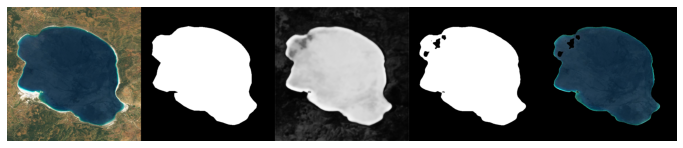

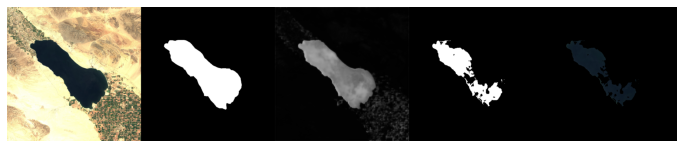

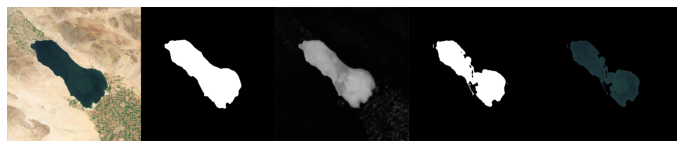

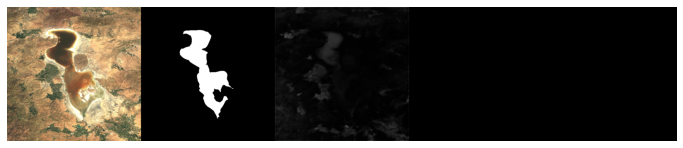

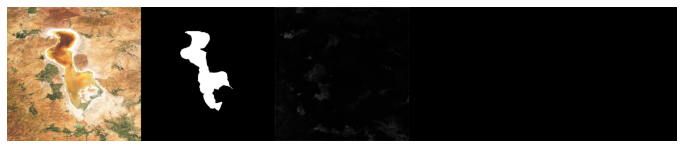

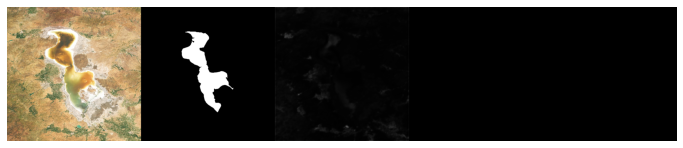

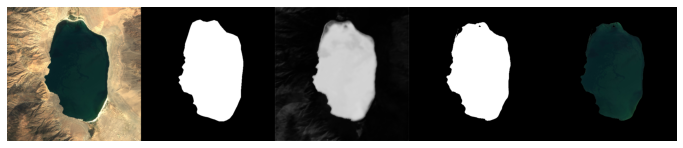

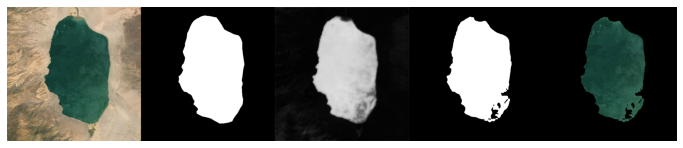

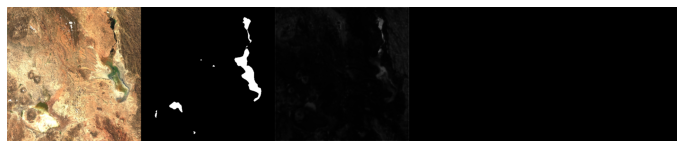

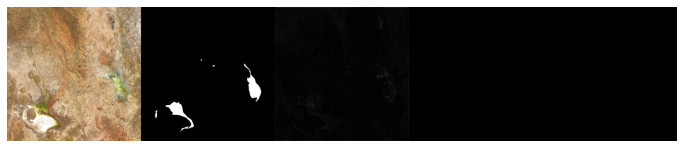

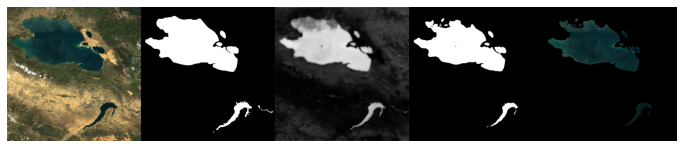

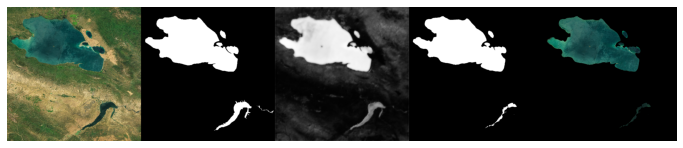

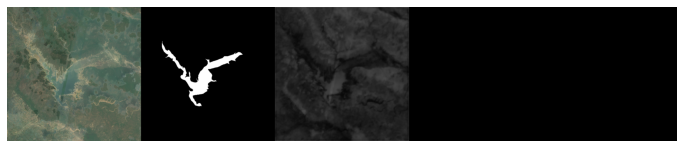

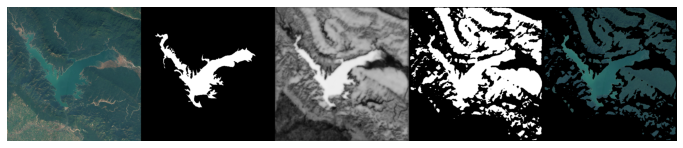

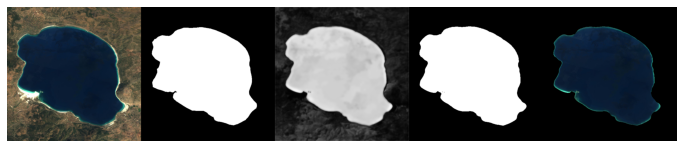

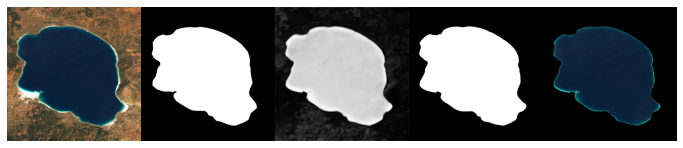

In [12]:
# Show results of predictions on the test images
# The model weights are loaded from the checkpoint file
# which contains the best weights as specified by the callback.
# If the file does not exist the model fitting step will have to
# be run.

model = UNet()
model.load_weights('unet_s2.h5')

for i in range(s2_valid_steps):
    test_X, test_y = next(s2_test_gen)
    preds = model.predict(test_X)
    for j in range(preds.shape[0]):
        img = test_X[j,:,:,:]
        msk = test_y[j,:,:,:].squeeze()
        pred = preds[j,:,:,:].squeeze()
        pred_t = (pred >= 0.5).astype(np.float32)

        msk = np.stack((msk,)*3, axis=-1)
        pred = np.stack((pred,)*3, axis=-1)
        pred_t = np.stack((pred_t,)*3, axis=-1)

        arr = np.concatenate([img, msk, pred, pred_t,img * pred_t],
                             axis=1)

        # Plot 
        plt.figure(figsize=(12,6))
        plt.axis('off')
        plt.imshow(arr)
        plt.show()

In [13]:
# Save history to pickle
with open('history_s2.pickle', 'wb') as f:
    pickle.dump(s2_history.history, f)

### S2 Cloudless - Augmented Data

Since the PlotLearning callback reads from disk I will first generate the augmented images and save them locally. For this I set the training proportion to 1 to process all images in a single generator; there is no need to split the data for this image saving task.

In [117]:
# Set up aug data generator

s2_aug_batch_size = 1 # just return a single image/mask pair each batch
s2_aug_prop_train = 1 # no need to split into test/train at this point

s2_aug_dict = {'zoom_range':0.2,
               'rotation_range':45,
               'horizontal_flip':True,
               'vertical_flip':True}

# No need to return file names here.
# Besides, since the data will be augmented the filenames
# will not correspond to the images generated, just the
# orignal base images
s2_aug_train_gen, s2_aug_test_gen = img_msk_generator(img_dir= s2_img_dir,
                                                      msk_dir= s2_msk_dir,
                                                      batch_size=s2_aug_batch_size,
                                                      train_prop=s2_aug_prop_train,
                                                      mask_threshold=128,
                                                      img_gen_kwargs={'rescale':1/255.},
                                                      aug_kwargs=s2_aug_dict)

Found 40 validated image filenames.
Found 40 validated image filenames.


In [9]:
num_aug_imgs = 100

# output directories for the agumented data
s2_aug_img_dir = os.path.join('s2cloudless_aug_imagery','data')
s2_aug_msk_dir = os.path.join('s2cloudless_aug_imagery','masks')

In [103]:
# Generate and save the augmented files to disk
# Note that by default, the save_img function will
# rescale the data to 0-255 and save as 8-bit uint files

for d in [s2_aug_img_dir, s2_aug_msk_dir]:
    os.makedirs(d, exist_ok=True)

imgs_made = 0
while imgs_made < num_aug_imgs:
    new_img, new_msk = next(s2_aug_train_gen)
    
    
    # The image number is zero padded here to ensure filename sorting maintains
    # the numeric order. If no padding is used, the file s2_aug_1.jpg would
    # be followed by s2_aug_10.jpg.
    # This order is not guaranteed to be kept when the _mask file are sorted.
    new_img_fn = f's2_aug_{imgs_made:03}.jpg'
    new_msk_fn = f's2_aug_{imgs_made:03}_mask.png' # to match format of real mask images
    
    save_img(os.path.join(s2_aug_img_dir, new_img_fn),
             new_img[0], 'channels_last')
    
    save_img(os.path.join(s2_aug_msk_dir, new_msk_fn),
             new_msk[0], 'channels_last')

    imgs_made += 1

Now that the images are stored locally they can be read in and split into train/test sets the same way as with the non-augmented data.

In [131]:
s2_aug_batch_size = 4
s2_aug_prop_train = 0.6

# No augmentations are applied here since the files are already
# aumgemented images!
(s2_aug_train_gen, s2_aug_test_gen,
 s2_aug_train_fns, s2_aug_test_fns) = img_msk_generator(img_dir= s2_aug_img_dir,
                                                        msk_dir= s2_aug_msk_dir,
                                                        batch_size=s2_aug_batch_size,
                                                        train_prop=s2_aug_prop_train,
                                                        train_shuffle=True,
                                                        train_seed=42,
                                                        return_fns=True,
                                                        mask_threshold=128,
                                                        img_gen_kwargs={'rescale':1/255.})


s2_aug_train_steps = len(s2_aug_train_fns) // s2_aug_batch_size
s2_aug_valid_steps = len(s2_aug_test_fns) // s2_aug_batch_size

print(f'Steps per training epoch: {s2_aug_train_steps}')
print(f'Steps per testing epoch: {s2_aug_valid_steps}')

Found 60 validated image filenames.
Found 60 validated image filenames.
Found 40 validated image filenames.
Found 40 validated image filenames.
Steps per training epoch: 15
Steps per testing epoch: 10


In [ ]:
# Configure callbacks
s2_aug_callbacks = [PlotLearning(test_img_dir=s2_aug_img_dir,
                                 test_img_fns=s2_aug_test_fns,
                                 epoch_freq=5, pred_threshold=0.5),
                    build_checkpointer(filepath='unet_s2_aug.h5')]

# Initialise model
model = UNet()

# Configure optimiser, loss, and metrics
s2_aug_opt = 'rmsprop' # default lr=0.001
# or decrease lr
# s2_aug_opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)

model.compile(s2_aug_opt,
              loss='binary_crossentropy',
              metrics =[mean_iou])

# Fit model
s2_aug_epochs = 100
s2_aug_history = model.fit(s2_aug_train_gen,
                           epochs=s2_aug_epochs,
                           steps_per_epoch=s2_aug_train_steps,
                           validation_data=s2_aug_test_gen,
                           validation_steps=s2_aug_valid_steps,
                           callbacks=s2_aug_callbacks,
                           verbose=0)

In [ ]:
# Save history to pickle
with open('history_s2_aug.pickle', 'wb') as f:
    pickle.dump(s2_aug_history.history, f)

### NWPU - Non Augmented Data

The NWPU images are 256 x 256 pixels wheras the default size for the `img_msk_generator` function and the input layer to the model is 512 x 512. Therefore, when training the UNet models with NWPU data I will specify this required image size.

In [9]:
nwpu_batch_size = 8
nwpu_prop_train = 0.6

# No augmentations
(nwpu_train_gen, nwpu_test_gen,
 nwpu_train_fns, nwpu_test_fns) = img_msk_generator(img_dir=nwpu_img_dir,
                                                    msk_dir=nwpu_msk_dir,
                                                    img_size=(256,256), # Specify image size
                                                    batch_size=nwpu_batch_size,
                                                    train_prop=nwpu_prop_train,
                                                    train_shuffle=True,
                                                    train_seed=42,
                                                    return_fns=True,
                                                    mask_threshold=128,
                                                    img_gen_kwargs={'rescale':1/255.}
                                                   )

nwpu_train_steps = len(nwpu_train_fns) // nwpu_batch_size
nwpu_valid_steps = len(nwpu_test_fns) // nwpu_batch_size

print(f'Steps per training epoch: {nwpu_train_steps}')
print(f'Steps per testing epoch: {nwpu_valid_steps}')

Found 240 validated image filenames.
Found 240 validated image filenames.
Found 160 validated image filenames.
Found 160 validated image filenames.
Steps per training epoch: 30
Steps per testing epoch: 20


In [ ]:
# Configure callbacks
nwpu_callbacks = [PlotLearning(test_img_dir=nwpu_img_dir,
                               test_img_fns=nwpu_test_fns,
                               epoch_freq=5, pred_threshold=0.5),
                  build_checkpointer(filepath='unet_nwpu.h5')]

# Initialise model specifying 256 x 256 x 3 input_shape
model = UNet(input_shape=(256,256,3))

# Configure optimiser, loss, and metrics
# Optimizer learning rate can be adjusted using an
# optimizer object e.g. tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer='rmsprop', # default lr=0.001; 
              loss='binary_crossentropy',
              metrics =[mean_iou])

# Fit model
nwpu_epochs = 30
nwpu_history = model.fit(nwpu_train_gen,
                         epochs=nwpu_epochs,
                         steps_per_epoch=nwpu_train_steps,
                         validation_data=nwpu_test_gen,
                         validation_steps=nwpu_valid_steps,
                         callbacks=nwpu_callbacks,
                         verbose=0)

In [ ]:
# Save history to pickle
with open('history_nwpu.pickle', 'wb') as f:
    pickle.dump(nwpu_history.history, f)

### NWPU - Augmented Data

In [13]:
# Set up aug data generator

nwpu_aug_batch_size = 1 # just return a single image/mask pair each batch
nwpu_aug_prop_train = 1 # no need to split into test/train at this point

nwpu_aug_dict = {'zoom_range':0.2,
                 'rotation_range':45,
                 'horizontal_flip':True,
                 'vertical_flip':True}

# No need to return file names here.
# Besides, since the data will be augmented the filenames
# will not correspond to the images generated, just the
# orignal base images
nwpu_aug_train_gen, nwpu_aug_test_gen = img_msk_generator(img_dir= nwpu_img_dir,
                                                          msk_dir= nwpu_msk_dir,
                                                          img_size=(256,256), # Specify image size
                                                          batch_size=nwpu_aug_batch_size,
                                                          train_prop=nwpu_aug_prop_train,
                                                          mask_threshold=128,
                                                          img_gen_kwargs={'rescale':1/255.},
                                                          aug_kwargs=nwpu_aug_dict)

Found 400 validated image filenames.
Found 400 validated image filenames.


In [10]:
num_aug_imgs = 1000

# output directories for the agumented data
nwpu_aug_img_dir = os.path.join('nwpu_aug_imagery','data')
nwpu_aug_msk_dir = os.path.join('nwpu_aug_imagery','masks')

In [15]:
# Generate and save the augmented files to disk
# Note that by default, the save_img function will
# rescale the data to 0-255 and save as 8-bit uint files

for d in [nwpu_aug_img_dir, nwpu_aug_msk_dir]:
    os.makedirs(d, exist_ok=True)

imgs_made = 0
while imgs_made < num_aug_imgs:
    new_img, new_msk = next(nwpu_aug_train_gen)
    
    
    # The image number is zero padded here to ensure filename sorting maintains
    # the numeric order. If no padding is used, the file nwpu_aug_1.jpg would
    # be followed by nwpu_aug_10.jpg.
    # This order is not guaranteed to be kept when the _mask file are sorted.
    new_img_fn = f'nwpu_aug_{imgs_made:03}.jpg'
    new_msk_fn = f'nwpu_aug_{imgs_made:03}_mask.png' # to match format of real mask images
    
    save_img(os.path.join(nwpu_aug_img_dir, new_img_fn),
             new_img[0], 'channels_last')
    
    save_img(os.path.join(nwpu_aug_msk_dir, new_msk_fn),
             new_msk[0], 'channels_last')

    imgs_made += 1

In [36]:
nwpu_aug_batch_size = 10 # trying a larger batch size
nwpu_aug_prop_train = 0.6

# No augmentations are applied here since the files are already
# aumgemented images!
(nwpu_aug_train_gen, nwpu_aug_test_gen,
 nwpu_aug_train_fns, nwpu_aug_test_fns) = img_msk_generator(img_dir= nwpu_aug_img_dir,
                                                            msk_dir= nwpu_aug_msk_dir,
                                                            img_size=(256,256), # Specify image size
                                                            batch_size=nwpu_aug_batch_size,
                                                            train_prop=nwpu_aug_prop_train,
                                                            train_shuffle=True,
                                                            train_seed=42,
                                                            return_fns=True,
                                                            mask_threshold=128,
                                                            img_gen_kwargs={'rescale':1/255.})


nwpu_aug_train_steps = len(nwpu_aug_train_fns) // nwpu_aug_batch_size
nwpu_aug_valid_steps = len(nwpu_aug_test_fns) // nwpu_aug_batch_size

print(f'Steps per training epoch: {nwpu_aug_train_steps}')
print(f'Steps per testing epoch: {nwpu_aug_valid_steps}')

Found 600 validated image filenames.
Found 600 validated image filenames.
Found 400 validated image filenames.
Found 400 validated image filenames.
Steps per training epoch: 60
Steps per testing epoch: 40


In [ ]:
# Add an early stopping callback since this training could take a long time.
# Here the training will stop if val_loss does not improve by 1e-3 for 10 epochs.
# The epoch number at which training has stopped will be shown (verbose=1).
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', min_delta=1e-3,
                                      patience=10,restore_best_weights=True, verbose=1)

# Configure callbacks
nwpu_aug_callbacks = [PlotLearning(test_img_dir=nwpu_aug_img_dir,
                                   test_img_fns=nwpu_aug_test_fns,
                                   epoch_freq=5, pred_threshold=0.5),
                      build_checkpointer(filepath='unet_nwpu_aug.h5'),
                      es]

# Initialise model specifying 256 x 256 x 3 input_shape
model = UNet(input_shape=(256,256,3))

# Configure optimiser, loss, and metrics
# Optimizer learning rate can be adjusted using an
# optimizer object e.g. tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer='rmsprop', # default lr=0.001; 
              loss='binary_crossentropy',
              metrics =[mean_iou])

# Fit model
nwpu_aug_epochs = 50 # could go higher but limited GPU time
nwpu_aug_history = model.fit(nwpu_aug_train_gen,
                             epochs=nwpu_aug_epochs,
                             steps_per_epoch=nwpu_aug_train_steps,
                             validation_data=nwpu_aug_test_gen,
                             validation_steps=nwpu_aug_valid_steps,
                             callbacks=nwpu_aug_callbacks,
                             verbose=0)

In [ ]:
# Save history to pickle
with open('history_nwpu_aug.pickle', 'wb') as f:
    pickle.dump(nwpu_aug_history.history, f)

**NOTE:**
For training each of these models, the `val_loss` was monitored to determine the checkpoint and best weights via `ModelCheckpoint`. However, this could have been set to `val_mean_iou` as that is ultimately what is being used to measure the performance of the model. The two metrics will not necessarily result in the same best weights!

For `EarlyStopping` the `val_loss` should be used since loss is key to the training process. See https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

## Evaluation
Plot the learning curves to assess the model training process.

In [27]:
def plot_model_history(history_df, title=''):
    """Plot model training history.
    
    The dataframe should include measurements of loss/val_loss
    and mean_iou/val_mean_iou
    """
    
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    loss_ax, iou_ax = axes
    
    # Plot loss
    history_df[['loss','val_loss']].plot(ax=loss_ax)
    val_loss_min_x = history_df.val_loss.argmin()
    val_loss_min_y = history_df.val_loss.min()
    loss_ax.plot([val_loss_min_x] * 2, [0, val_loss_min_y], color='g')
    loss_ax.plot([0, val_loss_min_x], [val_loss_min_y] * 2)
    loss_ax.scatter(val_loss_min_x, val_loss_min_y, s=100, marker='o',color='g')
    loss_ax.set_title(f'Loss\nMin @ Epoch:{val_loss_min_x}, Val:{val_loss_min_y:.4f}')
    loss_ax.set_ylim(0,1)
    loss_ax.set_xlim(0,len(history_df))

    # Plot mean_iou
    history_df[['mean_iou','val_mean_iou']].plot(ax=iou_ax)
    val_iou_max_x = history_df.val_mean_iou.argmax()
    val_iou_max_y = history_df.val_mean_iou.max()
    iou_ax.plot([val_iou_max_x] * 2, [0, val_iou_max_y], color='g')
    iou_ax.plot([0,val_iou_max_x],[val_iou_max_y]*2)
    iou_ax.scatter(val_iou_max_x, val_iou_max_y, s=100, marker='o',color='g')
    iou_ax.set_title(f'Mean IoU\nMax @ Epoch:{val_iou_max_x}, Val:{val_iou_max_y:.4f}')
    iou_ax.set_ylim(0,1)
    iou_ax.set_xlim(0,len(history_df))

    fig.suptitle(title);

### S2 Cloudless

In [3]:
with open('history_s2.pickle', 'rb') as f:
    s2_history = pickle.load(f)
    
with open('history_s2_aug.pickle', 'rb') as f:
    s2_aug_history = pickle.load(f)

In [4]:
print(s2_history.keys())

dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou'])


In [5]:
s2_history_df = pd.DataFrame(s2_history)
s2_aug_history_df = pd.DataFrame(s2_aug_history)

In [6]:
# Statistics for s2_history
s2_history_df.describe()

loss   mean_iou   val_loss  val_mean_iou
count   30.000000  30.000000  30.000000     30.000000
mean     9.315940   0.423681   0.295292      0.376999
std     34.234286   0.246661   0.139187      0.357773
min      0.164409   0.000000   0.135139      0.000000
25%      0.193348   0.322846   0.215607      0.009765
50%      0.215296   0.468780   0.254900      0.263761
75%      0.366761   0.612745   0.303666      0.769292
max    142.635956   0.717672   0.641067      0.815814

In [7]:
# Statistics for s2_aug_history
s2_aug_history_df.describe()

loss    mean_iou    val_loss  val_mean_iou
count  100.000000  100.000000  100.000000    100.000000
mean     3.548761    0.722601    0.153516      0.686622
std     21.943868    0.188734    0.073547      0.180680
min      0.055016    0.000000    0.073373      0.000000
25%      0.087371    0.725341    0.099001      0.699846
50%      0.114035    0.781116    0.141339      0.729699
75%      0.161269    0.818363    0.188822      0.763854
max    197.123444    0.873081    0.587904      0.829360

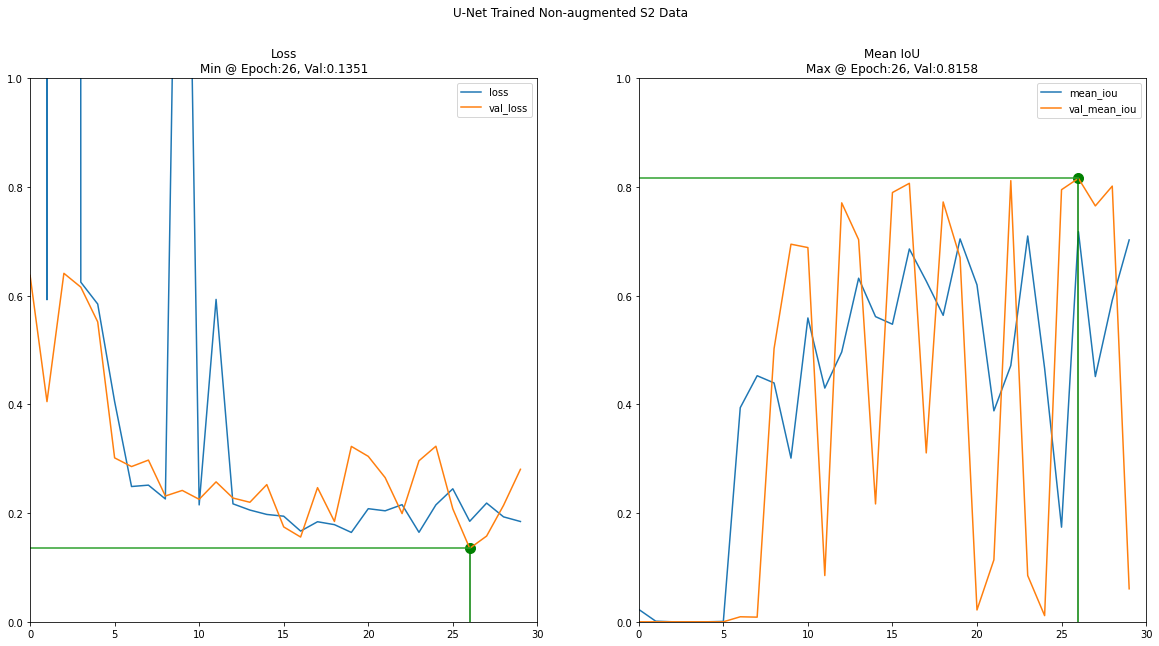

In [17]:
plot_model_history(s2_history_df,title='U-Net Trained Non-augmented S2 Data')

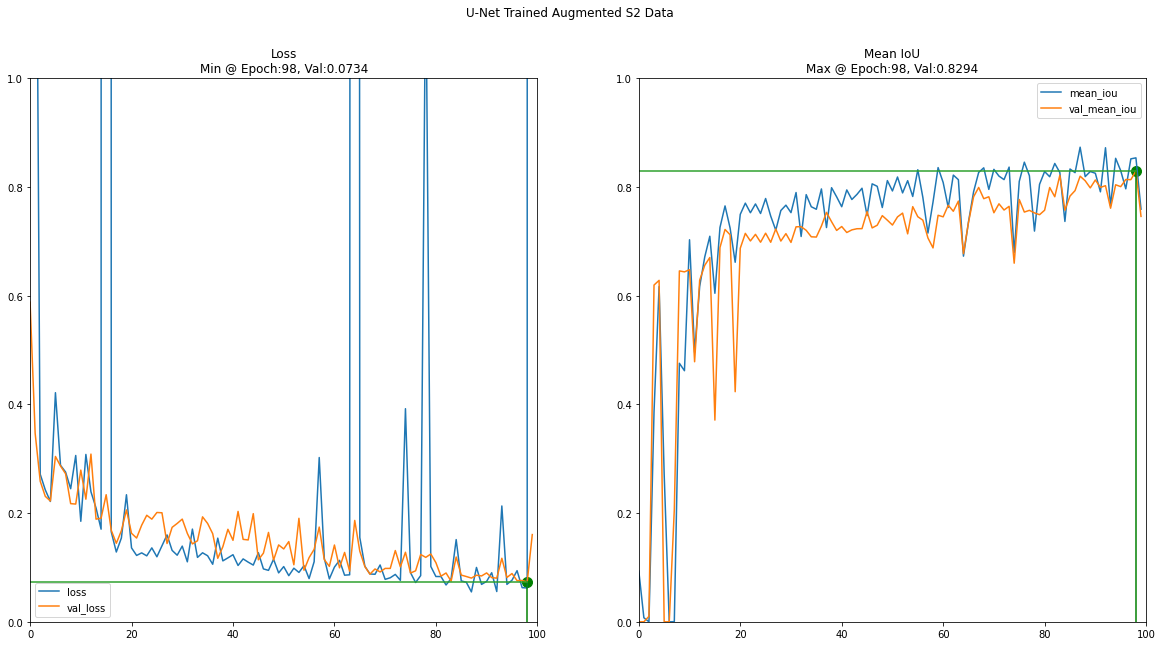

In [89]:
plot_model_history(s2_aug_history_df,title='U-Net Trained Augmented S2 Data')

The model trainined with the augmented data manages to achieve a best `val_mean_iou` value of 82.9% compared to 81.5% with the non-augmented data; a difference of 1.4%. The best `val_loss` is also achieved when using the augmented data. This would suggest that augmentation does indeed help the model generalise better.

The model trained on the non-augmented data shows that generally, throughout learning, the performance on the validation data was better than on the trainining data; this is suspicious and could be due to several factors (see below). However, the model trained on the augmented data looks a bit more sensible with the training performance generally being superior. 

The training and validation losses are quite noisey though the training loss shows much more variance; standard deviation of 34 (versus 0.139) for the non-augmented data and 21 (versus 0.074) for the augmented data. This could be due to a learning rate that is too high, leading to bouncing around the global minimum (see below).

Similarly, the training and validation `mean_iou` values are noisey though exhibit a similar variance.

#### Noisey Learning Curves
Some common causes of noisey curves are:
1. Learning Rate to high
    * This can cause the loss to bounce around the minium leading to large fluctuations
2. Local Minima
    * If a local minima is found it can produce a good loss but not optimal. If the Gradient Descent algorithm is able to escape the local minima the loss will increase but it may go on to find a better or global minima.
3. Small Batch Size
    * Since the loss is averaged over all batches in the epoch, a small batch size means many more measurements of loss to be averaged.
    * Further, the variance between small batches could be large; each batch may not be very representive of the whole data.
    * As a result, the average loss for each epoch can vary greatly.
    * However, smaller batch sizes increase the chance of escaping local minima so there is a trade off.
    
See these Stack Exchange questions ([Q1](https://stackoverflow.com/questions/48579315/noisy-training-loss), [Q2](https://datascience.stackexchange.com/questions/12532/does-batch-size-in-keras-have-any-effects-in-results-quality)) for some useful discussions.


#### Validation Loss better than Training Loss
Generally this can happen if the validation data is "easier" than the training data. Therefore one should consider how the training and validation split was achieved and if it is likely that validation images are easier to classify or perhaps some data leakage has occured e.g. some images from the training set included in the validation set.

Also consider the size of the entire training datset. If it is small (like the non-augmented S2 dataset) then it may not be enough to really model the problem and the respective train/validation splits likely wont capture the same trends i.e. they are samples from a small population. This difference could lead to the validation data being easier and therefore producing a smaller loss / greater mean IoU.

One way to combat this and get a better idea of model performance would be to use cross-validation such as `KFoldCrossValidation`. This does come at the expense of having to train several versions of the model however.

See these links ([L1](https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/), [L2](https://stackoverflow.com/questions/56575293/validation-loss-is-lower-than-training-loss-training-lstm), [L3](https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error)) for some useful discussions.

### NWPU

In [18]:
with open('history_nwpu.pickle', 'rb') as f:
    nwpu_history = pickle.load(f)
    
with open('history_nwpu_aug.pickle', 'rb') as f:
    nwpu_aug_history = pickle.load(f)

In [19]:
print(nwpu_history.keys())

dict_keys(['loss', 'mean_iou', 'val_loss', 'val_mean_iou'])


In [20]:
nwpu_history_df = pd.DataFrame(nwpu_history)
nwpu_aug_history_df = pd.DataFrame(nwpu_aug_history)

In [21]:
# Statistics for nwpu_history
nwpu_history_df.describe()

loss   mean_iou   val_loss  val_mean_iou
count  30.000000  30.000000  30.000000     30.000000
mean    0.818633   0.683706   0.235788      0.597867
std     3.274183   0.136881   0.043026      0.134021
min     0.145442   0.028712   0.173997      0.033520
25%     0.162491   0.680198   0.211567      0.573907
50%     0.181939   0.716403   0.228773      0.622724
75%     0.224278   0.748747   0.254445      0.677490
max    18.130318   0.767001   0.374743      0.726456

In [23]:
# Statistics for nwpu_aug_history
nwpu_aug_history_df.describe()

loss   mean_iou   val_loss  val_mean_iou
count  50.000000  50.000000  50.000000     50.000000
mean    1.534923   0.789393   0.230849      0.781724
std     9.858460   0.107594   0.724018      0.130402
min     0.071292   0.196127   0.072025      0.055266
25%     0.085365   0.751976   0.087376      0.733806
50%     0.131564   0.807558   0.110142      0.822548
75%     0.169988   0.861372   0.163430      0.856371
max    69.849144   0.883618   5.235182      0.877648

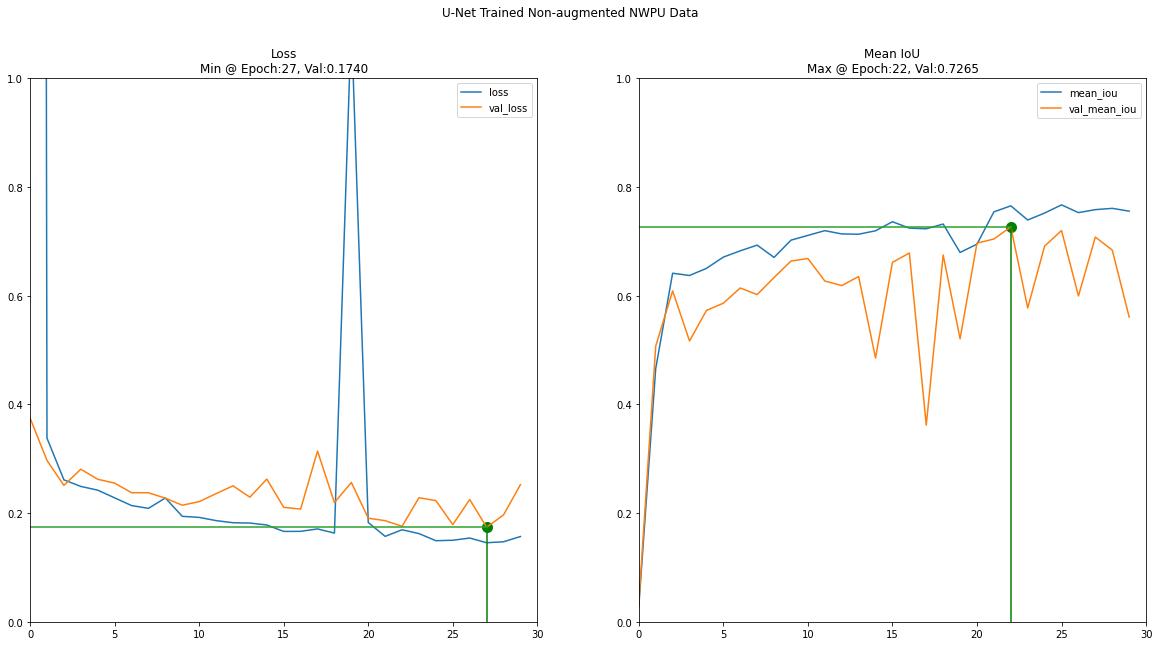

In [28]:
plot_model_history(nwpu_history_df,title='U-Net Trained Non-augmented NWPU Data')

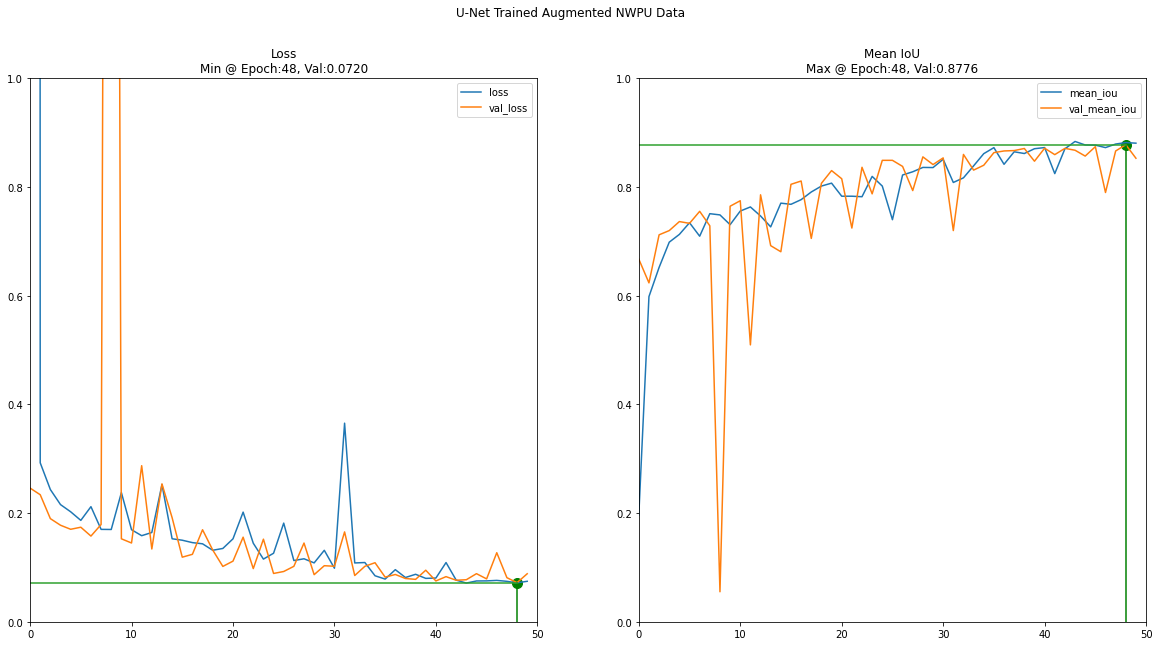

In [30]:
plot_model_history(nwpu_aug_history_df,title='U-Net Trained Augmented NWPU Data')

The model trainined with the augmented data manages to achieve a best `val_mean_iou` value of 87.7% compared to 72.7% with the non-augmented data; a difference of 15%. The best `val_loss` is also achieved when using the augmented data. This would suggest that augmentation does indeed help the model generalise better.

Note that in the case of the non-augmented model, the epoch where `val_loss` is at its minimum is different to the epoch where `val_mean_iou` is at its maximum. Recall that during training the best weights saved for the model were determined by the `val_loss` metric. Therefore a model using the best weights (saved at epoch 27) will not necessarily achieve the best `val_mean_iou` that can be seen here at epoch 22.

In the case of the augmented data model, both the loss and mean_iou show performance is better on the validation set for the most part. From epoch 42 this switches and the better performance can be seen in the training set. The non-augmented results look as expected with the training performance generally being superior. Note that this is the reverse of the situation seen in the S2 results.

Similar to the models trained using the S2 data, the learning curves are a bit noisy. The training loss again shows more variance than the validation loss for both the non-agumented and the augmented data models. The variance for the `mean_iou` is again very similar across the training and validation results for both models.

## Testing

The above results show the performance of each model on the corresponding validation images i.e NWPU `val_mean_iou` on the NWPU validation set.

I'm also interested to see how a model trained on one set of images performs on the other i.e. NWPU `val_mean_iou` on the S2 imagery and vice versa. Since the models accept different input sizes I will ensure that appropriate resizing is performed.

In this case will only examine the augmented models as they performed better than their non-augmented counterparts. When evaluating one model using the other model's imagery I will use the full set of data (training + validation) since the model will not have seen any of these other images before.

### S2 Cloudless

In [44]:
model = UNet()
model.load_weights('unet_s2_aug.h5')

# need to compile as only the model weights were saved and the
# model.evaluate method needs to know what metrics to calculate.
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics =[mean_iou])

In [45]:
# Evaluate on augmented S2 imagery (validation set)

# The batch_size, train_prop, and train_seed value are the
# same as used earlier for model training. This ensures
# the same images are selected.
s2_aug_batch_size = 4
s2_aug_prop_train = 0.6

(s2_aug_train_gen, s2_aug_test_gen,
 s2_aug_train_fns, s2_aug_test_fns) = img_msk_generator(img_dir= s2_aug_img_dir,
                                                        msk_dir= s2_aug_msk_dir,
                                                        batch_size=s2_aug_batch_size,
                                                        train_prop=s2_aug_prop_train,
                                                        train_shuffle=True,
                                                        train_seed=42,
                                                        return_fns=True,
                                                        mask_threshold=128,
                                                        img_gen_kwargs={'rescale':1/255.})

steps = len(s2_aug_test_fns) // s2_aug_batch_size

# Evaluate
s2_results_s2 = model.evaluate(s2_aug_test_gen, steps=steps)

Found 60 validated image filenames.
Found 60 validated image filenames.
Found 40 validated image filenames.
Found 40 validated image filenames.
10/10 [==============================] - 30s 3s/step - loss: 0.0734 - mean_iou: 0.8294


This is the same result shown in the learning curve charts above.

In [47]:
# Evaluate on augmented NWPU imagery (all images)

# Set up generator for NWPU imagery at 512 x 512 resolution
# Using the default img_size of 512 x 512 will cause the
# NWPU images to be upsampled from their native 256 x 256
# resolution.
nwpu_train_gen_512, _ = img_msk_generator(img_dir= nwpu_aug_img_dir,
                                          msk_dir= nwpu_aug_msk_dir,
                                          batch_size=4,
                                          train_prop=1,
                                          mask_threshold=128,
                                          img_gen_kwargs={'rescale':1/255.})

# Evaluate
s2_results_nwpu = model.evaluate(nwpu_train_gen_512, steps=250) # 250 steps of 4 = 1000 images

Found 1000 validated image filenames.
Found 1000 validated image filenames.
250/250 [==============================] - 1205s 5s/step - loss: 0.3157 - mean_iou: 0.6109


In [48]:
print(f'S2 Imagery - Loss: {s2_results_s2[0]:.4f}; Mean IoU: {s2_results_s2[1]:.4f}')
print(f'NWPU Imagery - Loss: {s2_results_nwpu[0]:.4f}; Mean IoU: {s2_results_nwpu[1]:.4f}')

S2 Imagery - Loss: 0.0734; Mean IoU: 0.8294
NWPU Imagery - Loss: 0.3157; Mean IoU: 0.6109


### NWPU

In [50]:
model = UNet(input_shape=(256,256,3))
model.load_weights('unet_nwpu_aug.h5')
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics =[mean_iou])

In [51]:
# Evaluate on augmented NWPU imagery (validation set)

# The batch_size, train_prop, and train_seed value are the
# same as used earlier for model training. This ensures
# the same images are selected.
nwpu_aug_batch_size = 10
nwpu_aug_prop_train = 0.6

(nwpu_aug_train_gen, nwpu_aug_test_gen,
 nwpu_aug_train_fns, nwpu_aug_test_fns) = img_msk_generator(img_dir= nwpu_aug_img_dir,
                                                            msk_dir= nwpu_aug_msk_dir,
                                                            img_size=(256,256), # Specify image size
                                                            batch_size=nwpu_aug_batch_size,
                                                            train_prop=nwpu_aug_prop_train,
                                                            train_shuffle=True,
                                                            train_seed=42,
                                                            return_fns=True,
                                                            mask_threshold=128,
                                                            img_gen_kwargs={'rescale':1/255.})

steps = len(nwpu_aug_test_fns) // nwpu_aug_batch_size

# Evaluate
nwpu_results_nwpu = model.evaluate(nwpu_aug_test_gen, steps=steps)

Found 600 validated image filenames.
Found 600 validated image filenames.
Found 400 validated image filenames.
Found 400 validated image filenames.
40/40 [==============================] - 82s 2s/step - loss: 0.0720 - mean_iou: 0.8776


This is the same result shown in the learning curve charts above.

In [52]:
# Evaluate on augmented S2 imagery (all images)

# Set up generator for S2 imagery at 256 x 256 resolution
# Specifying img_size=(256, 256) will cause the S2 images
# to be downsampled from their native 512 x 512 resolution.
s2_train_gen_256, _ = img_msk_generator(img_dir= s2_aug_img_dir,
                                        msk_dir= s2_aug_msk_dir,
                                        img_size=(256,256),
                                        batch_size=10,
                                        train_prop=1,
                                        mask_threshold=128,
                                        img_gen_kwargs={'rescale':1/255.})

# Evaluate
nwpu_results_s2 = model.evaluate(s2_train_gen_256, steps=10)

Found 100 validated image filenames.
Found 100 validated image filenames.
10/10 [==============================] - 18s 2s/step - loss: 0.1406 - mean_iou: 0.7334


In [53]:
print(f'NWPU Imagery - Loss: {nwpu_results_nwpu[0]:.4f}; Mean IoU: {nwpu_results_nwpu[1]:.4f}')
print(f'S2 Imagery - Loss: {nwpu_results_s2[0]:.4f}; Mean IoU: {nwpu_results_s2[1]:.4f}')

NWPU Imagery - Loss: 0.0720; Mean IoU: 0.8776
S2 Imagery - Loss: 0.1406; Mean IoU: 0.7334


### Conclusion
Both augmented models performed reasonably well on their own validation sets with the S2 model achieving a `val_mean_iou` of 82.9% and the NWPU model 87.8%.

When evaluated using the training (and validation) set of images from the other model, performance was mixed. The S2 model only achieved 61.1% `val_mean_iou` on the NWPU images whereas the NWPU model faired a bit better on the S2 images at 73.3%.

Since the images are from different sources - Sentinel-2 versus Google Earth - I would not expect the models to achieve a similar accuracy on both datasets. It should also be noted that the NWPU model was trained with 10x as many images as the S2 model (600 training images versus 60). Another point to consider is that to preprocess the NWPU images for the S2 model they had to be upsampled from their original resolution of 256 x 256 to 512 x 512. This process essentially creates data where there was previously none (via interpolation) which could also contribute to poorer performance - this would be interesting to verify!

I will next move focus to tune the NWPU model to perform better on the S2 imagery. For now, I have a base model and a performance baseline to compare subsquent models to.